In [ ]:
# default_exp funcs.visualization

In [ ]:
%load_ext autoreload
%autoreload 2

# Visualization tools 

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope, get_roi_filt_inds, mic_inp_apply_inds, extract_psf_roi
from decode_fish.engine.point_process import PointProcessUniform
from matplotlib.backends.backend_agg import FigureCanvas
import kornia

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
from decode_fish.funcs.exp_specific import get_mop_codebook
cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_17/phasing:0.0/train.yaml')

In [ ]:
cfg.genm.microscope.col_shifts_enabled =  True
cfg.genm.microscope.col_shifts_yxds =  [2048, 2048, 50]

In [ ]:
cfg.training.bs = 1
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
codebook, target = get_mop_codebook()
post_proc.codebook = torch.tensor(codebook)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
7 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# export
def get_simulation_statistics(decode_dl, micro, int_conc, int_rate, int_loc, int_threshold=1, samples = 1, channels=1, n_bits=1, psf_noise=True, const_theta_sim=True):
        
    """
    Draws a sample from the dataloader, and plots a slice of the real volume and the simulated volume.
    """ 
    z_ind = decode_dl.dataset.dataset_tfms[0].crop_sz[0]//2
    with torch.no_grad():
        
        for _ in range(samples):
        
            xmax = 0
            while xmax <= int_threshold:
                ret_dict = next(iter(decode_dl))
                xmax = ret_dict['x'][0,0,z_ind].max()
                
            rand_ch = np.random.randint(0,channels)
                
            sim_vars = PointProcessUniform(ret_dict['local_rate'][:,0],int_conc, int_rate, int_loc, channels=channels, n_bits=n_bits, sim_z=True,
                                  codebook=None, int_option=3).sample(from_code_book=False, phasing=False)
            ch_inp = micro.get_single_ch_inputs(*sim_vars[:-1])
            xsim = micro(*ch_inp, add_noise=psf_noise)
            xsim = micro.noise(xsim, ret_dict['background'], const_theta_sim=const_theta_sim).sample()
            
            sim_df = sample_to_df(*sim_vars[:5], sim_vars[-1], px_size_zyx=[1.,1.,1.])
            sim_df = sim_df[sim_df['frame_idx'] == 0]
            sim_df = sim_df[sim_df[f'int_{rand_ch}'] > 0]
            
            x = cpu(ret_dict['x'][0,rand_ch])
            xsim = cpu(xsim[0,rand_ch])

            fig1, axes = plot_3d_projections(x, display=False)
            fig2, axes = plot_3d_projections(xsim, display=False)
            scat_3d_projections(axes, sim_df)
            
            figure = combine_figures([fig1,fig2],[f'Channel {rand_ch}','Simulation'], nrows=1, ncols=2, figsize=(20,10))
            figure.suptitle('Max projection', fontsize=15, y=0.9)

[autoreload of decode_fish.engine.place_psfs failed: Traceback (most recent call last):
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in u

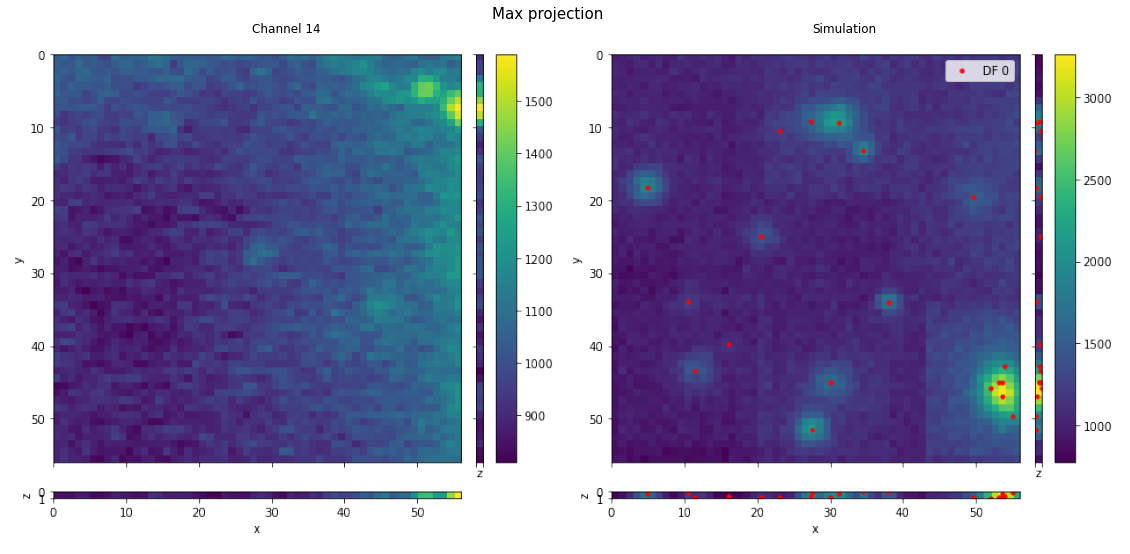

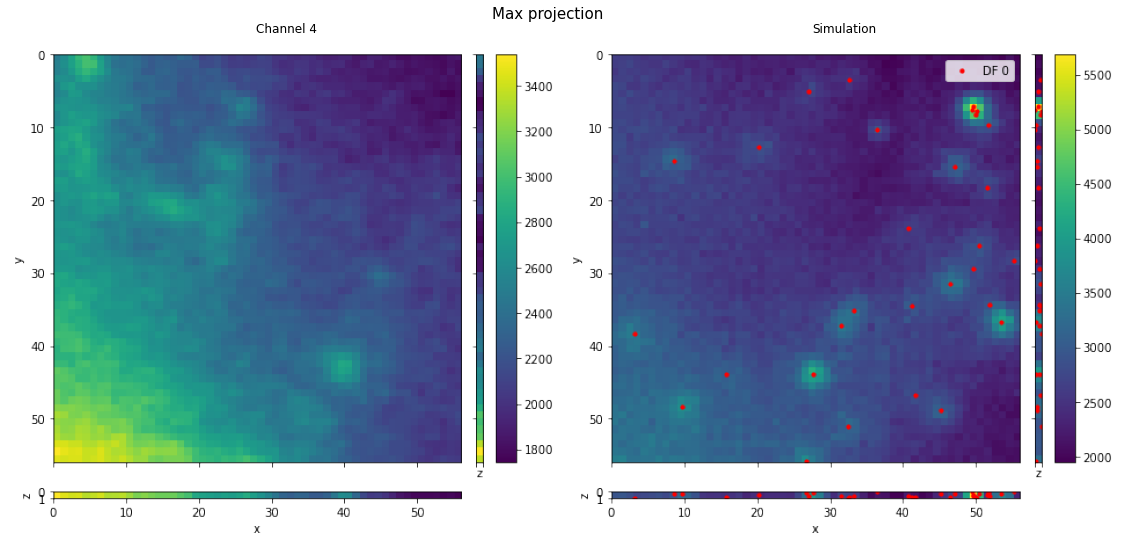

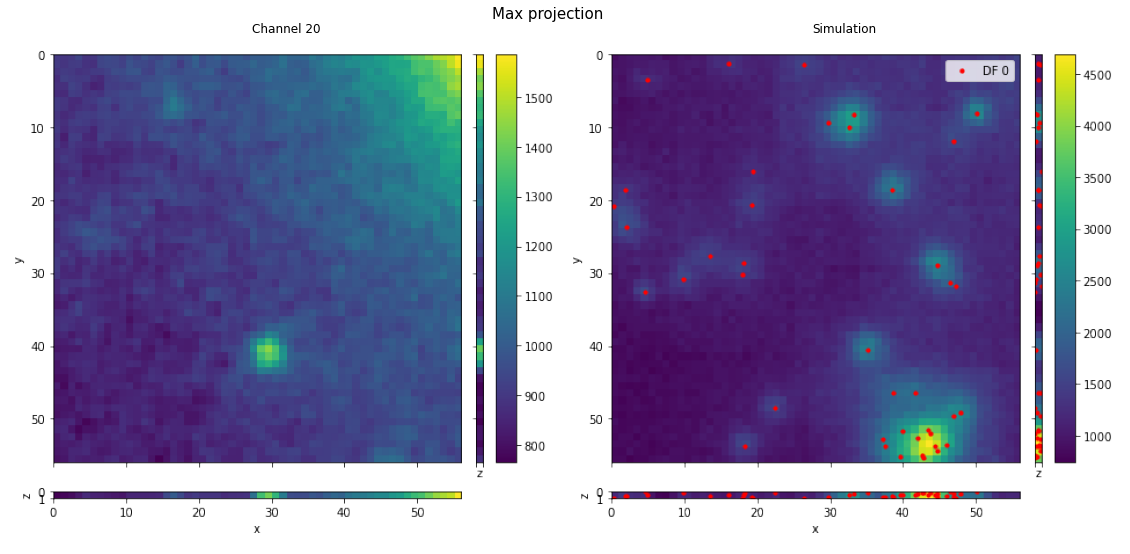

In [ ]:
get_simulation_statistics(decode_dl, micro, **cfg.genm.intensity_dist, int_threshold=0.1, samples=3, channels=cfg.genm.exp_type.n_channels, n_bits=cfg.genm.exp_type.n_bits, psf_noise=False)

In [ ]:
# export
def get_prediction(model, post_proc, img, micro=None, cuda=True, return_rec=False):
    
    with torch.no_grad():
        
        img = img[(None,)*(5-img.ndim)]
        model.eval().cuda() if cuda else model.eval().cpu()
        res_dict = model(img.cuda()) if cuda else model(img)
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        
        if return_rec:
            micro_inp = post_proc.get_micro_inp(res_dict)
            ch_inp = micro.get_single_ch_inputs(*micro_inp)
            ae_img_3d = micro(*ch_inp)   
            
            filt_inds = get_roi_filt_inds(*ch_inp[0], micro.psf.psf_volume.shape, img.shape, slice_rec=micro.slice_rec, min_dist=10)
            ch_inp = mic_inp_apply_inds(*ch_inp, filt_inds)
            if len(ch_inp[1]):
                psf_recs = micro(*ch_inp, ret_psfs=True, add_noise=False)  
#                         print('N rec inds ', len(psf_recs))

                rois = extract_psf_roi(ch_inp[0], img, torch.tensor(psf_recs.shape))
                psf_bgs = extract_psf_roi(ch_inp[0], res_dict['background'], torch.tensor(psf_recs.shape))
            else: 
                psf_recs = rois = psf_bgs = None
            
            return pred_df, ae_img_3d + res_dict['background'], res_dict, psf_recs, psf_bgs, rois, ch_inp
            
        return pred_df

In [ ]:
# export
def eval_random_crop(decode_dl, model, post_proc, micro, proj_func=np.max, cuda=False, samples=1, int_threshold=1, plot='rec', crop_sz_xy=40, ret_preds=False):
    
    with torch.no_grad():
        
        dl_copy = copy.deepcopy(decode_dl)
        dl_copy.dataset.dataset_tfms[0].crop_sz = (dl_copy.dataset.dataset_tfms[0].crop_sz[0], crop_sz_xy, crop_sz_xy)
        
        if ret_preds: samples = 1
        
        for _ in range(samples):
        
            x = torch.zeros(1)
            while x.max() < int_threshold:
                ret_dict = next(iter(decode_dl))
                x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'] 
                zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
                background = background * micro.get_ch_mult().detach()
                x = x * micro.get_ch_mult().detach()
                x = x[:1]
                
            if micro.col_shifts_enabled:
                colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, x.shape[-1])
                colshift_crop = colshift_crop[:1]
                net_inp = torch.concat([x,colshift_crop], 1)
            else:
                net_inp = x
        
            rand_ch = np.random.randint(0, x.shape[1])
            print(rand_ch)
            pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = get_prediction(model, post_proc, net_inp, micro=micro, cuda=True, return_rec=True)
            pred_df = nm_to_px(pred_df, post_proc.px_size_zyx)
            
            sub_df = pred_df[cpu(post_proc.codebook)[pred_df['code_inds']][:,rand_ch] > 0]

            x_plot = x[0,rand_ch].cpu().numpy()
            rec = rec[0,rand_ch].cpu().numpy()

            if plot is not None:
            
                fig1, axes = plot_3d_projections(x_plot, proj_func=proj_func, display=False)
                scat_3d_projections(axes, [sub_df])

                if 'res' in plot:

                    diff = x_plot-rec
                    fig2, axes = plot_3d_projections(diff, proj_func=proj_func, display=False)
                    combine_figures([fig1,fig2], ['Predictions', 'Residual'], figsize=(20,10))

                if 'rec' in plot:

                    fig2, axes = plot_3d_projections(rec, proj_func=proj_func, display=False)
                    combine_figures([fig1,fig2], ['Predictions', 'Reconstruction'], figsize=(20,10))

                if 'bg' in plot:
                    fig2, axes = plot_3d_projections(res_dict['background'][0,rand_ch].cpu().numpy(), proj_func=proj_func, display=False)
                    combine_figures([fig1,fig2], ['Predictions', 'BG pred.'], figsize=(20,10))
                
            plt.show()
                
        if ret_preds:
            
            return x, local_rate, background, pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp
                        

19


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (7) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


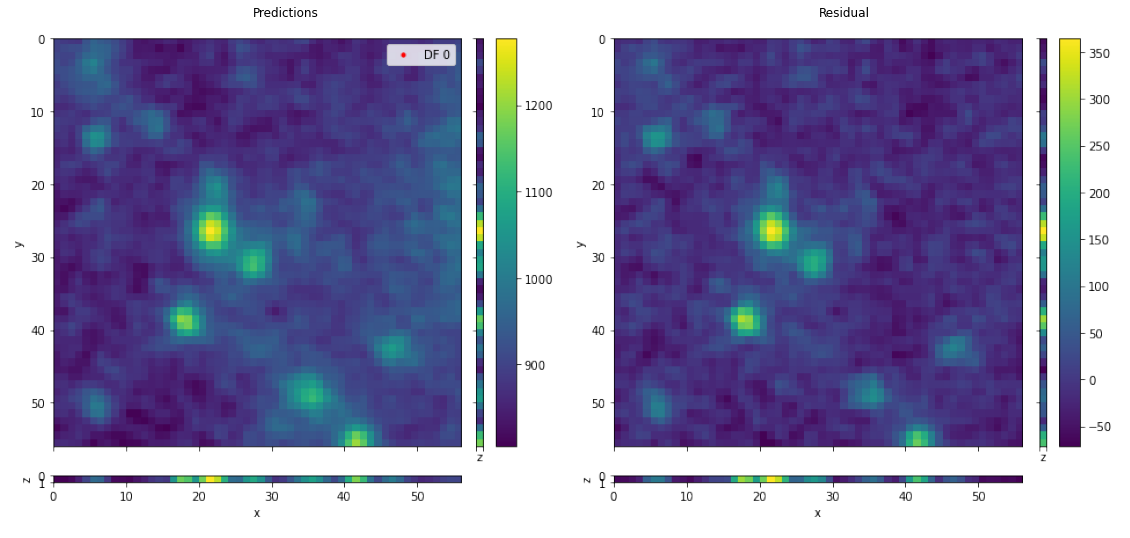

In [ ]:
x, local_rate, background, pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = eval_random_crop(decode_dl, model, post_proc, micro, plot='res', crop_sz_xy=100, ret_preds=True)

In [ ]:
rois.shape

torch.Size([4, 1, 1, 21, 21])

In [ ]:
micro.noise(psf_recs, psf_bgs, const_theta_sim=False).log_prob(rois.clamp_min_(1.))[0,0] - micro.noise(psf_recs, psf_bgs, const_theta_sim=False).log_prob(rois.clamp_min_(1.))[0,7]

tensor([[[324.1437, 331.9083, 338.3209, 342.8188, 338.5210, 332.9995, 327.9521,
          326.2776, 325.7330, 329.3240, 330.6289, 328.3022, 327.4312, 324.6018,
          322.4042, 322.4453, 325.7195, 326.8925, 325.2289, 325.5154, 331.1301],
         [322.4828, 327.9557, 331.7502, 335.1948, 335.2638, 333.8945, 329.5957,
          326.3604, 326.6388, 331.3435, 332.3418, 328.1232, 325.9619, 323.9071,
          319.0051, 317.6989, 321.5129, 325.6284, 326.9358, 327.3369, 329.4841],
         [322.9507, 328.5928, 326.7438, 327.6000, 330.3790, 332.7839, 331.0566,
          327.4166, 327.3228, 331.1436, 330.9065, 325.1495, 323.8684, 323.8276,
          319.7433, 317.2620, 317.4702, 321.4177, 326.1628, 326.9678, 327.7809],
         [325.4625, 330.5887, 327.1454, 327.5863, 329.3176, 333.5841, 334.9462,
          331.7852, 329.4913, 331.4343, 329.6256, 324.1912, 323.2666, 322.1761,
          318.0210, 315.7844, 315.5416, 319.0143, 326.0032, 329.0807, 328.6031],
         [325.2770, 331.7112, 329.98

(2, 11)


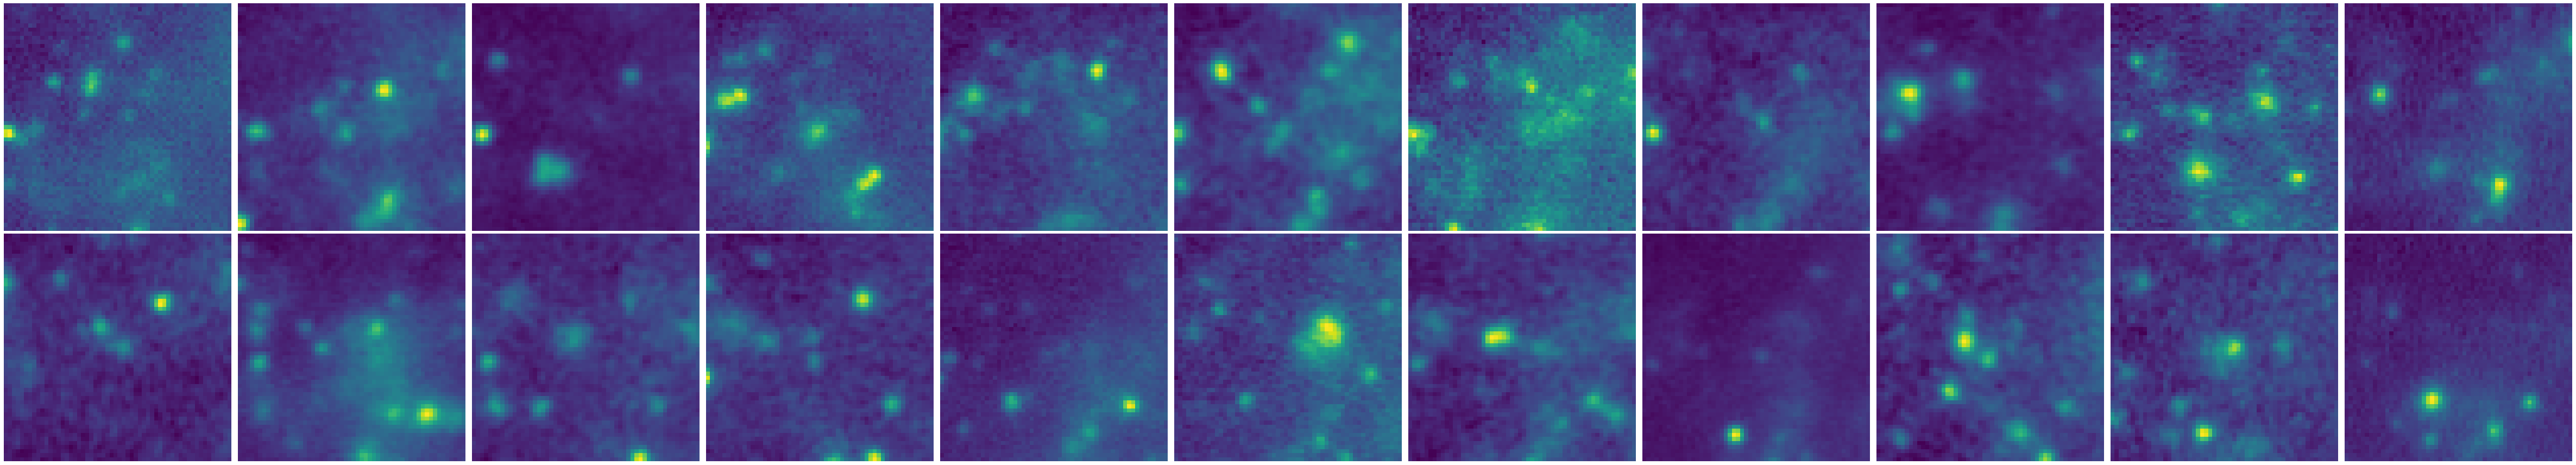

In [ ]:
_ = plot_channels(cpu(x),2)

(2, 11)


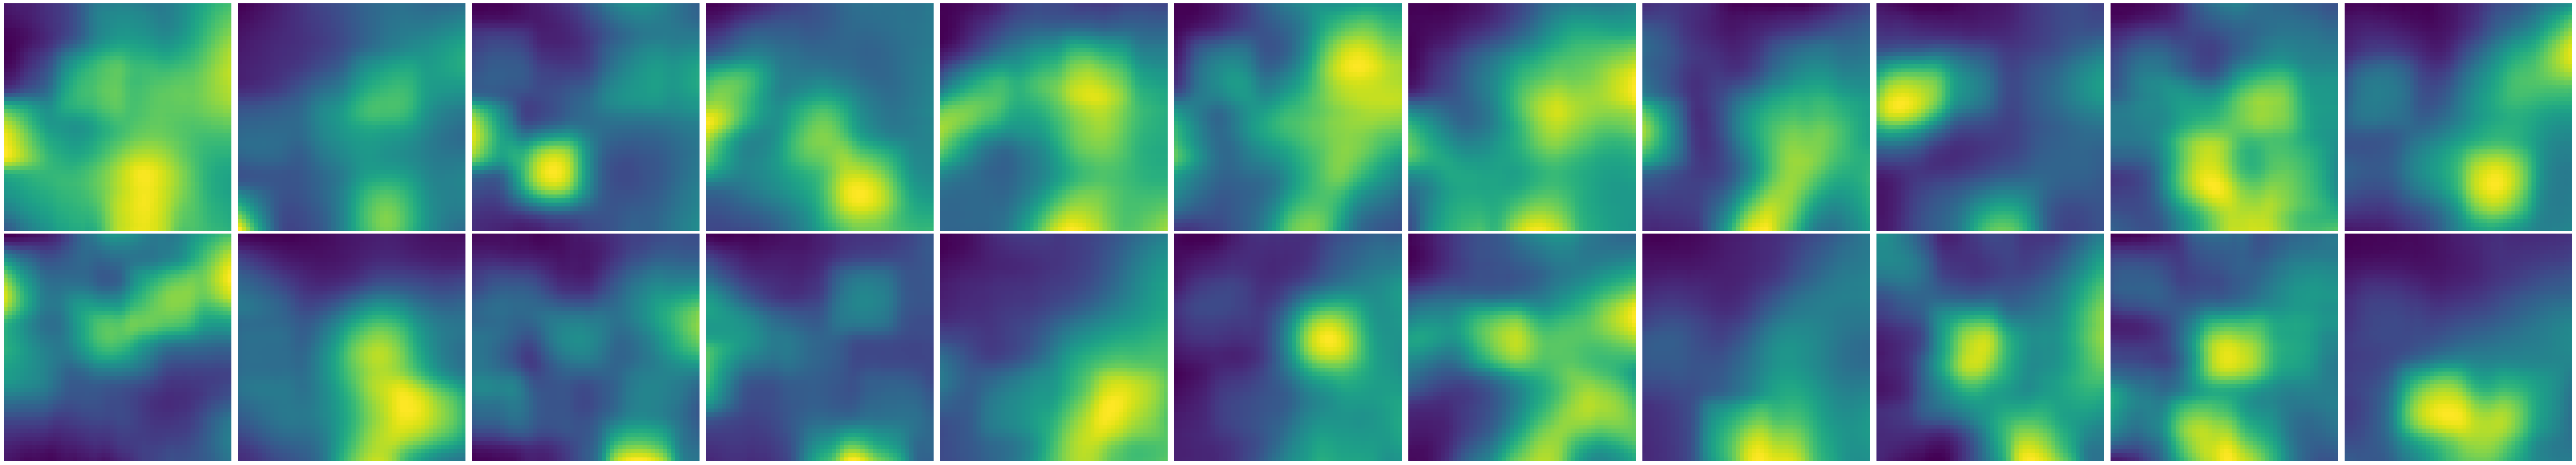

In [ ]:
_ = plot_channels(cpu(background),2)

(2, 11)


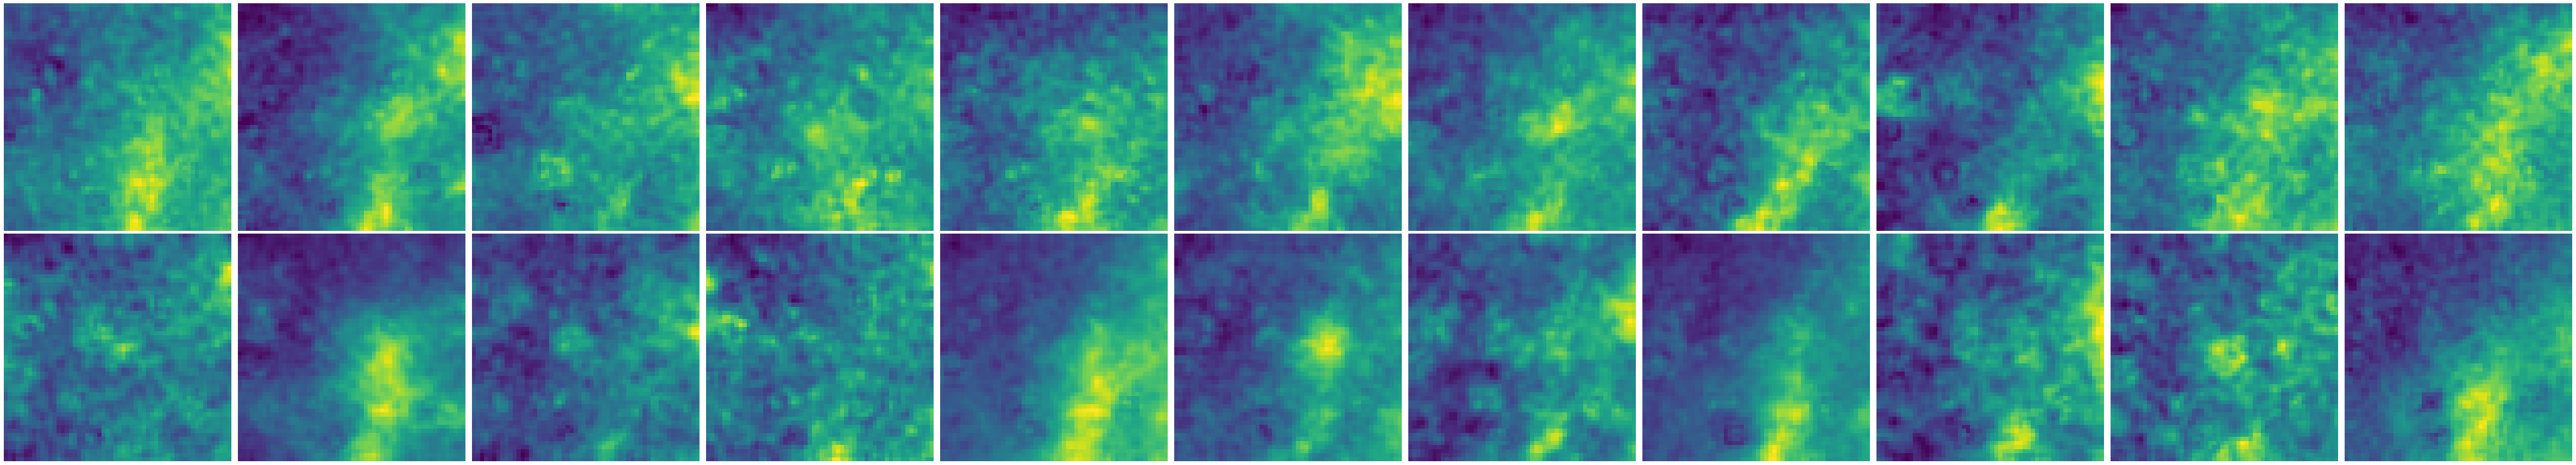

In [ ]:
_ = plot_channels(cpu(res_dict['background']),2)

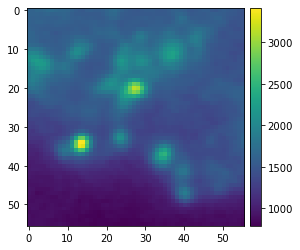

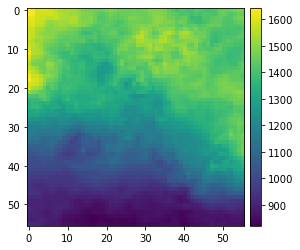

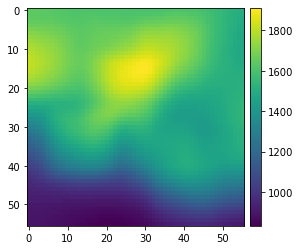

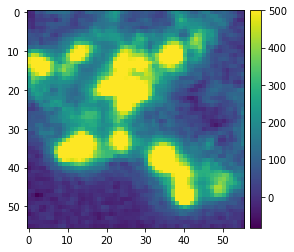

In [ ]:
im = plt.imshow(cpu(x[:,5])[0,0])
add_colorbar(im)
plt.show()
im = plt.imshow(cpu(res_dict['background'][:,5])[0,0])
add_colorbar(im)
plt.show()
im = plt.imshow(cpu(background[:,5])[0,0])
add_colorbar(im)
plt.show()
im = plt.imshow(cpu(x[:,5])[0,0]-cpu(res_dict['background'][:,5])[0,0], vmax=500)
add_colorbar(im)
plt.show()

146.15839


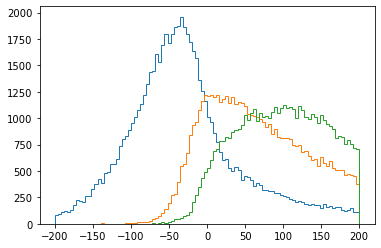

In [ ]:
_ = plt.hist(cpu(x-background).reshape(-1), histtype='step', bins=np.linspace(-200,200,101))
_ = plt.hist(cpu(x-res_dict['background']).reshape(-1), histtype='step', bins=np.linspace(-200,200,101))
_ = plt.hist(cpu(background-res_dict['background']).reshape(-1), histtype='step', bins=np.linspace(-200,200,101))
print(cpu(x-res_dict['background']).reshape(-1).mean())

In [ ]:
x.shape

torch.Size([1, 22, 1, 56, 56])

In [ ]:
# export
def eval_random_sim(decode_dl, model, post_proc, micro, proj_func=np.max, plot_gt=True, cuda=True, samples=1):
    
    with torch.no_grad():
        
        for _ in range(samples):
        
            ret_dict = next(iter(decode_dl))
            x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'] 
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']

            sim_vars = PointProcessUniform(local_rate[:,0] ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, sim_z=True, codebook=torch.tensor(codebook), int_option=cfg.training.int_option).sample(from_code_book=(codebook is not None))
            ch_inp = micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
            xsim = micro(*ch_inp, add_noise=True)
            
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[:1], micro=micro, cuda=True, return_rec=True)
            pred_df = nm_to_px(pred_df, post_proc.px_size_zyx)
            sim_df = nm_to_px(sample_to_df(*sim_vars[:-1]))
            sim_df = sim_df[sim_df['frame_idx']==0]

            x = x[0,0].cpu().numpy()
            rec = rec[0,0].cpu().numpy()

            fig1, axes = plot_3d_projections(x, proj_func=proj_func, display=False)
            scat_3d_projections(axes, [pred_df])

            fig2, axes = plot_3d_projections(x, proj_func=proj_func, display=False)

            combine_figures([fig1,fig2], ['Predictions', 'Reconstruction'], figsize=(20,10))

In [ ]:
eval_random_sim(decode_dl, model, post_proc, micro, proj_func=np.max, samples=3)

RuntimeError: Given groups=1, weight of size [192, 24, 1, 3, 3], expected input[1, 22, 1, 58, 58] to have 24 channels, but got 22 channels instead

In [ ]:
!nbdev_build_lib

In [ ]:
cfg.genm.exp_type.n_channels

22